In [1]:
from sklearn.datasets import fetch_openml

In [2]:
mnist = fetch_openml('mnist_784', as_frame = False)

In [3]:
X, y = mnist.data, mnist.target

In [4]:
X.shape

(70000, 784)

In [5]:
y

array(['5', '0', '4', ..., '4', '5', '6'], shape=(70000,), dtype=object)

In [6]:
y.shape

(70000,)

In [7]:
import matplotlib.pyplot as plt

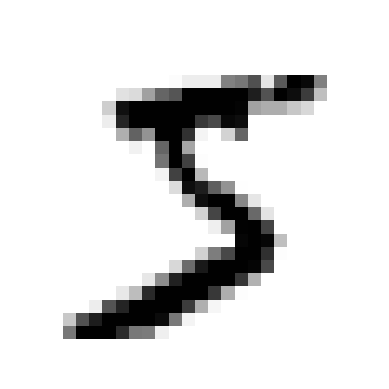

In [8]:
def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap = "binary")
    plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)
plt.show()

In [9]:
y[0]

'5'

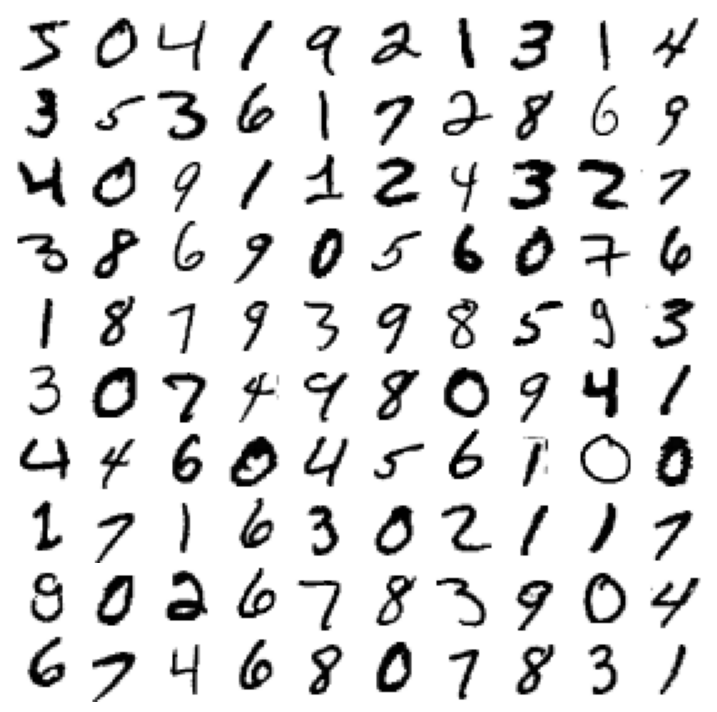

In [11]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "classification"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# extra code – this cell generates and saves Figure 3–2
plt.figure(figsize=(9, 9))
for idx, image_data in enumerate(X[:100]):
    plt.subplot(10, 10, idx + 1)
    plot_digit(image_data)
plt.subplots_adjust(wspace=0, hspace=0)
save_fig("more_digits_plot", tight_layout=False)
plt.show()

In [12]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training A Binary Classifier

In [13]:
y_train_5 = (y_train == '5')

In [14]:
y_test_5 = (y_test == '5')

In [15]:
from sklearn.linear_model import SGDClassifier

In [16]:
sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [17]:
sgd_clf.predict([some_digit])

array([ True])

## Performance Measures

### Measuring Accuracy Using Cross-Validation

In [18]:
from sklearn.model_selection import cross_val_score

In [19]:
cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [20]:
from sklearn.dummy import DummyClassifier

In [21]:
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)

print(any(dummy_clf.predict(X_train)))

False


In [22]:
cross_val_score(dummy_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.90965, 0.90965, 0.90965])

In [23]:
## Implementing Cross-Validation Manually
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits = 3)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold   = X_train[test_index]
    y_test_fold   = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred    = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


## Confusion Matrices

In [24]:
from sklearn.model_selection import cross_val_predict

In [25]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)
y_train_pred

array([ True, False, False, ...,  True, False, False], shape=(60000,))

In [26]:
from sklearn.metrics import confusion_matrix

In [27]:
print(y_train_5.dtype, y_train_pred.dtype)

print({type(v) for v in y_train_5[:10]})
print({type(v) for v in y_train_pred[:10]})
y_train_pred = y_train_pred.astype(bool)

bool bool
{<class 'numpy.bool'>}
{<class 'numpy.bool'>}


In [28]:
cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]])

In [29]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

In [30]:
from sklearn.metrics import precision_score, recall_score

In [31]:
precision_score(y_train_5, y_train_pred)

0.8370879772350012

## Precision and Recall

In [32]:
from sklearn.metrics import precision_score, recall_score

In [33]:
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [34]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [35]:
from sklearn.metrics import f1_score

In [36]:
f1_score(y_train_5, y_train_pred)

0.7325171197343847

In [37]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [39]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [42]:
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [43]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method = "decision_function")

In [45]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

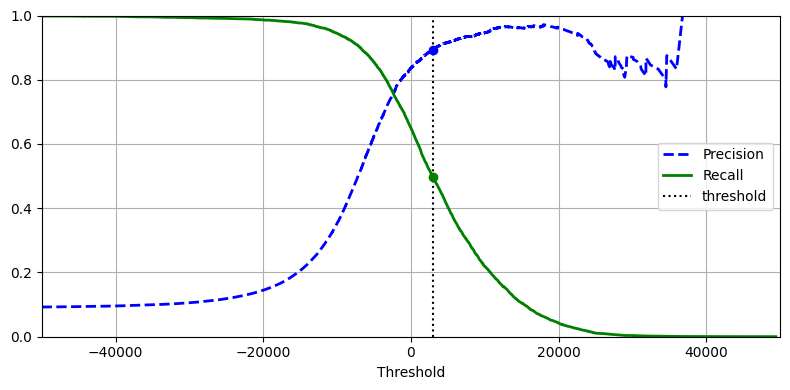

In [51]:
plt.figure(figsize=(8, 4))  # extra code – it's not needed, just formatting
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")

# extra code – this section just beautifies and saves Figure 3–5
idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")
save_fig("precision_recall_vs_threshold_plot")

plt.show()

In [52]:
# plt.plot(thresholds, precisions[:-1], "b--", label = "Precision", linewidth = 2)
# plt.plot(thresholds, recalls[:-1], "g-", label = "Recall", linewidth = 2)
# plt.vlines(threshold, 0, 1.0, "k", "dotted", label = "threshold")
# plt.show()

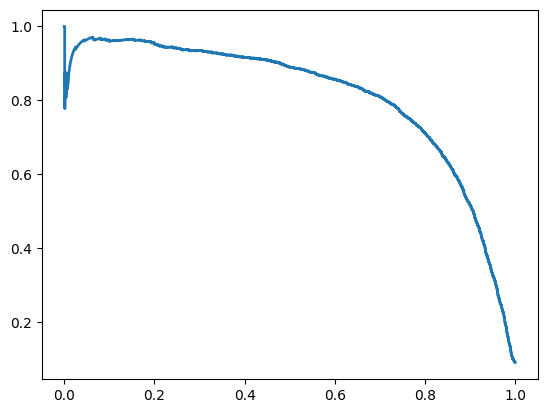

In [ ]:
# plt.plot(recalls, precisions, linewidth = 2, label = "Precision/Recall curve")
# plt.show()

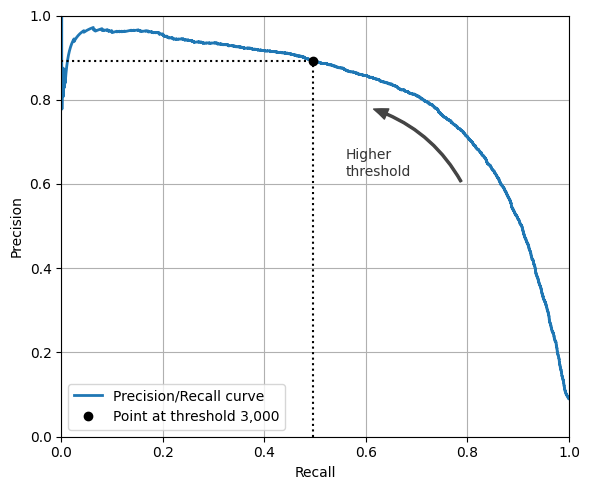

In [53]:
import matplotlib.patches as patches  # extra code – for the curved arrow

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

# extra code – just beautifies and saves Figure 3–6
plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold 3,000")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
save_fig("precision_vs_recall_plot")

plt.show()

In [55]:
# search for the lowest threshold that gives you at least 90% precision
idx_for_90_prediction      = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_prediction]
threshold_for_90_precision

np.float64(3370.0194991439557)

In [56]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

In [ ]:
precision_score(y_train_5, y_train_pred_90)

In [57]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision

0.4799852425751706

## The ROC Curve

In [58]:
from sklearn.metrics import roc_curve

In [60]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [61]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

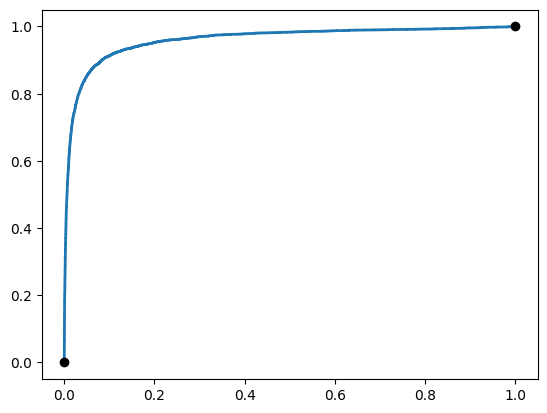

In [65]:
plt.plot(fpr, tpr, linewidth = 2, label= "ROC Curve")
plt.plot([0, 1], [0, 1], "ko", label = "Threshold for 90% precision")
plt.show()

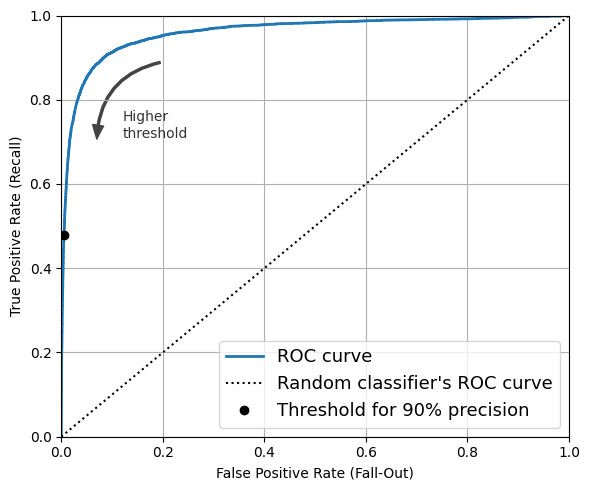

In [67]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

# extra code – just beautifies and saves Figure 3–7
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)
save_fig("roc_curve_plot")

plt.show()

In [69]:
# estimate the ROC AUC: a perfect classifier would have a ROC AUC of 1
from sklearn.metrics import roc_auc_score

In [70]:
roc_auc_score(y_train_5, y_scores)

np.float64(0.9604938554008616)

In [72]:
# Train RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

In [73]:
forest_clf = RandomForestClassifier(random_state = 42)

In [74]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3, method = "predict_proba")

In [75]:
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

In [80]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

In [ ]:
# plt.plot(recalls_forest, precisions_forest, "b-", linewidth = 2, label = "Random Forest")
# plt.plot(recalls, precisions, "--", linewidth = 2, label = "SGD")
# plt.show()

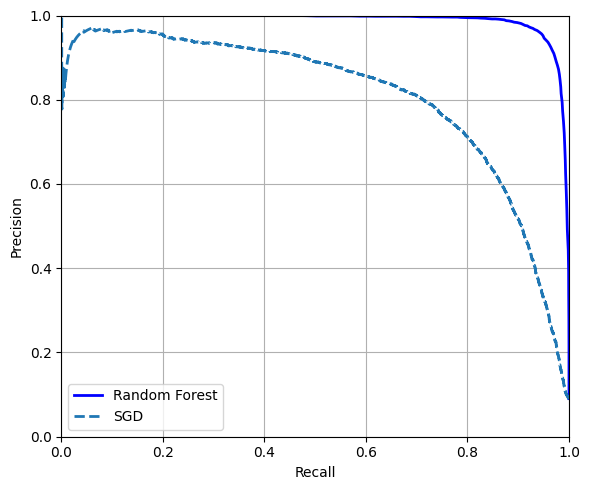

In [82]:
plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2,
         label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")

# extra code – just beautifies and saves Figure 3–8
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
save_fig("pr_curve_comparison_plot")

plt.show()

In [84]:
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5
print(f1_score(y_train_5, y_train_pred_forest))
print(roc_auc_score(y_train_5, y_scores_forest))

0.9274509803921569
0.9983436731328145
